In [204]:
import tensorcircuit as tc
import tensorflow as ts 
import numpy as np
import math
from numpy import linalg as LA
from matplotlib import pyplot as plt
K = tc.set_backend("tensorflow")
tc.set_dtype("complex128")

sim_t = math.pi
interval = 20
dt = sim_t / interval
cur_t = 0 
h_m = 0.5

qubit = 5
min_w = 999
w=0
v=0
I = tc.gates._i_matrix
X = tc.gates._x_matrix  
Y = tc.gates._y_matrix  
Z = tc.gates._z_matrix




In [205]:
def i_iterate_multiplication(u):
    tmp = 1
    for i in range(u):
        tmp = np.kron(I, tmp)
    return tmp

def zzi(i):
     return np.kron(np.kron(i_iterate_multiplication(i), np.kron(Z, Z)), i_iterate_multiplication(qubit-2-i))
def xi(i):
    return np.kron(np.kron(i_iterate_multiplication(i), X), i_iterate_multiplication(qubit-1-i))
def zi(i):
    return np.kron(np.kron(i_iterate_multiplication(i), Z), i_iterate_multiplication(qubit-1-i))

h_Z = 0
h_ZZ = 0
h_X = 0
for i in range(qubit):
    h_Z = h_Z + zi(i)
for i in range(qubit-1):
    h_ZZ = h_ZZ - zzi(i)
for i in range(qubit):
    h_X = h_X + h_m * xi(i)
def evolution(h, t):
    return tc.gates.exponential_gate(h, t)

In [206]:
#w, v = LA.eig(H)
#for i in range(0, len(w)):
#        if w[i] < min_w:
#            min_w = w[i]

c_precise = tc.Circuit(qubit)
c_trotter3 = tc.Circuit(qubit)
c_trotter2 = tc.Circuit(qubit)
state_precise = c_precise.state()
state_trotter3 = c_trotter3.state()
state_trotter2 = c_trotter2.state()
cnt=0;
zt2=[0 for i in range(10000)]
zt3=[0 for i in range(10000)]
zp=[0 for i in range(10000)]
time=[0 for i in range(10000)]
u2=1/(4-4**(1/3))


for _interval in range(interval):
    if(_interval % 5 == 0):
        print(_interval)
    c_precise = tc.Circuit(qubit, inputs = state_precise)
    c_trotter3 = tc.Circuit(qubit, inputs = state_trotter3)
    c_trotter2 = tc.Circuit(qubit, inputs = state_trotter2)
    
    c_trotter3.any(*range(qubit), unitary=evolution(h_X, u2*dt/2))
    c_trotter3.any(*range(qubit), unitary=evolution(h_ZZ, u2*dt))
    c_trotter3.any(*range(qubit), unitary=evolution(h_X, 0.5*u2*dt))
    
    c_trotter3.any(*range(qubit), unitary=evolution(h_X, (1-4*u2)*dt/2))
    c_trotter3.any(*range(qubit), unitary=evolution(h_ZZ, (1-4*u2)*dt))
    c_trotter3.any(*range(qubit), unitary=evolution(h_X, 0.5*(1-4*u2)*dt))
    
    c_trotter3.any(*range(qubit), unitary=evolution(h_X, u2*dt/2))
    c_trotter3.any(*range(qubit), unitary=evolution(h_ZZ, u2*dt))
    c_trotter3.any(*range(qubit), unitary=evolution(h_X, 0.5*u2*dt))
    c_trotter3.any(*range(qubit), unitary=evolution(h_X, u2*dt/2))
    c_trotter3.any(*range(qubit), unitary=evolution(h_ZZ, u2*dt))
    c_trotter3.any(*range(qubit), unitary=evolution(h_X, 0.5*u2*dt))
    
    c_trotter2.any(*range(qubit), unitary=evolution(h_X, dt))
    c_trotter2.any(*range(qubit), unitary=evolution(h_ZZ, dt))
    cur_t += dt
    c_precise.any(*range(qubit), unitary=evolution(h_ZZ+h_X, dt))
    zt3[cnt]=c_trotter3.expectation((h_Z, [*range(qubit)]))
    zt2[cnt]=c_trotter2.expectation((h_Z, [*range(qubit)]))
    zp[cnt]=c_precise.expectation((h_Z, [*range(qubit)]))
    time[cnt]=cur_t
    cnt+=1
    state_precise = c_precise.state()
    state_trotter3 = c_trotter3.state()
    state_trotter2 = c_trotter2.state()


0
5
10
15


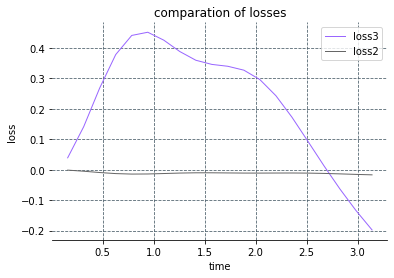

In [209]:
fig, ax = plt.subplots() 
plt.plot([time[i] for i in range(interval)], [zt3[i]-zp[i] for i in range(interval)], color = "#9966FF", lw = 1,label="loss3") 
plt.plot([time[i] for i in range(interval)], [zt2[i]-zp[i] for i in range(interval)], color = "#666666", lw = 1,label="loss2")
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(ls = "--", lw = 0.8, color = "#4E616C")
ax.set_xlabel("time") 
ax.set_ylabel("loss")
ax.set_title("comparation of losses") 
plt.legend() 
plt.show()